In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# إعدادات عامة
img_size = (224, 224)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE
data_dir = "data"

# تحميل وتقسيم البيانات
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# عدد التصنيفات
num_classes = len(train_ds.class_names)

# تحسين الأداء
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# تحميل EfficientNetB0
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

# بناء النموذج
inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)  # ← تم التعديل هنا

model = models.Model(inputs, outputs)

# تجميع النموذج
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')
earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy', mode='max')

# التدريب الأساسي
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# Fine-tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) // 2
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Found 2390 files belonging to 5 classes.
Using 1912 files for training.
Found 2390 files belonging to 5 classes.
Using 478 files for validation.
Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.2080 - loss: 1.7191 

60/60 ━━━━━━━━━━━━━━━━━━━━ 61s 883ms/step - accuracy: 0.2086 - loss: 1.7180 - val_accuracy: 0.4372 - val_loss: 1.4291
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.3983 - loss: 1.4474 

60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 868ms/step - accuracy: 0.3989 - loss: 1.4464 - val_accuracy: 0.6109 - val_loss: 1.1943
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.5108 - loss: 1.2575 

60/60 ━━━━━━━━━━━━━━━━━━━━ 50s 841ms/step - accuracy: 0.5114 - loss: 1.2566 - val_accuracy: 0.7071 - val_loss: 1.0282
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.6195 - loss: 1.0857 

60/60 ━━━━━━━━━━━━━━━━━━━━ 50s 830ms/step - accuracy: 0.6197 - loss: 1.0852 - val_accuracy: 0.7385 - val_loss: 0.9092
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.6733 - loss: 0.9687 

60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 860ms/step - accuracy: 0.6734 - loss: 0.9681 - val_accuracy: 0.7762 - val_loss: 0.8190
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.6821 - loss: 0.9036 

60/60 ━━━━━━━━━━━━━━━━━━━━ 53s 884ms/step - accuracy: 0.6825 - loss: 0.9031 - val_accuracy: 0.7908 - val_loss: 0.7495
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.7361 - loss: 0.8250 

60/60 ━━━━━━━━━━━━━━━━━━━━ 48s 795ms/step - accuracy: 0.7361 - loss: 0.8246 - val_accuracy: 0.8075 - val_loss: 0.6937
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.7644 - loss: 0.7544 

60/60 ━━━━━━━━━━━━━━━━━━━━ 48s 799ms/step - accuracy: 0.7644 - loss: 0.7544 - val_accuracy: 0.8159 - val_loss: 0.6485
Epoch 9/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.7824 - loss: 0.6987 

60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 765ms/step - accuracy: 0.7824 - loss: 0.6987 - val_accuracy: 0.8347 - val_loss: 0.6123
Epoch 10/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 781ms/step - accuracy: 0.7930 - loss: 0.6772 - val_accuracy: 0.8326 - val_loss: 0.5817
Epoch 11/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 770ms/step - accuracy: 0.7871 - loss: 0.6640 - val_accuracy: 0.8347 - val_loss: 0.5561
Epoch 12/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.8020 - loss: 0.6219 

60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 772ms/step - accuracy: 0.8019 - loss: 0.6218 - val_accuracy: 0.8452 - val_loss: 0.5334
Epoch 13/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.8168 - loss: 0.5966 

60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 765ms/step - accuracy: 0.8167 - loss: 0.5966 - val_accuracy: 0.8515 - val_loss: 0.5140
Epoch 14/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.8322 - loss: 0.5684 

60/60 ━━━━━━━━━━━━━━━━━━━━ 50s 838ms/step - accuracy: 0.8322 - loss: 0.5682 - val_accuracy: 0.8536 - val_loss: 0.4972
Epoch 15/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.8316 - loss: 0.5616 

60/60 ━━━━━━━━━━━━━━━━━━━━ 49s 825ms/step - accuracy: 0.8314 - loss: 0.5616 - val_accuracy: 0.8577 - val_loss: 0.4823
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.6479 - loss: 1.0050 - val_accuracy: 0.8556 - val_loss: 0.4963
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7146 - loss: 0.8817  

60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7148 - loss: 0.8812 - val_accuracy: 0.8598 - val_loss: 0.5105
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7526 - loss: 0.7910  

60/60 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.7526 - loss: 0.7906 - val_accuracy: 0.8661 - val_loss: 0.5121
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7748 - loss: 0.7202  

60/60 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.7749 - loss: 0.7199 - val_accuracy: 0.8703 - val_loss: 0.5006
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7873 - loss: 0.6728 - val_accuracy: 0.8682 - val_loss: 0.4826
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8201 - loss: 0.6172  

60/60 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.8201 - loss: 0.6169 - val_accuracy: 0.8724 - val_loss: 0.4600
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8292 - loss: 0.5634  

60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8292 - loss: 0.5633 - val_accuracy: 0.8787 - val_loss: 0.4387
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8699 - loss: 0.5126  

60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8698 - loss: 0.5125 - val_accuracy: 0.8849 - val_loss: 0.4174
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8443 - loss: 0.4991 - val_accuracy: 0.8828 - val_loss: 0.3966
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8474 - loss: 0.4787 - val_accuracy: 0.8849 - val_loss: 0.3782


In [5]:
# 1. فك التجميد عن الطبقات الأساسية في الموديل
base_model.trainable = True

# 2. إعادة الكومبايل بـ Learning Rate أقل
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3. التدريب الإضافي (fine-tuning)
fine_tune_epochs = 5
total_epochs = 15 + fine_tune_epochs  # عشان نرسم كل المراحل لاحقًا

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=15,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 16/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.8560 - loss: 0.4934 - val_accuracy: 0.8828 - val_loss: 0.3949
Epoch 17/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8567 - loss: 0.4709 - val_accuracy: 0.8828 - val_loss: 0.3744
Epoch 18/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8641 - loss: 0.4441  

60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8642 - loss: 0.4440 - val_accuracy: 0.8891 - val_loss: 0.3570
Epoch 19/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9064 - loss: 0.3756  

60/60 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9061 - loss: 0.3759 - val_accuracy: 0.8912 - val_loss: 0.3416
Epoch 20/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8877 - loss: 0.3768  

60/60 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8878 - loss: 0.3767 - val_accuracy: 0.8975 - val_loss: 0.3290


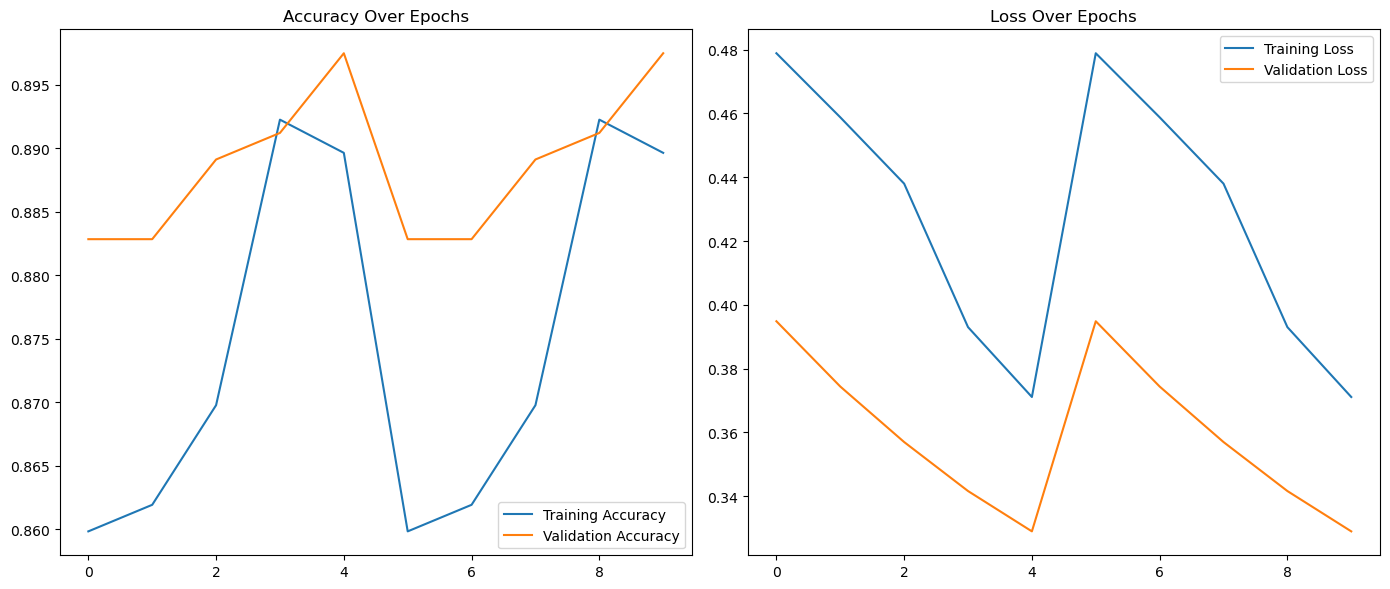

In [9]:
import matplotlib.pyplot as plt

# 1. دمج history الأساسي مع fine-tuning
acc = history_finetune.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy'] + history_finetune.history['val_accuracy']

loss = history_finetune.history['loss'] + history_finetune.history['loss']
val_loss = history_finetune.history['val_loss'] + history_finetune.history['val_loss']

epochs_range = range(len(acc))

# 2. رسم الإحصائيات
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Over Epochs')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss Over Epochs')

plt.tight_layout()
plt.show()